# Data Science Project - Michal Hagoel & Omer Sharoni

## Project name:
### What makes a hit song

## Research Question:
### Can we predict wether or not a song will become a hit based on multiple factors such as genre, length and more.

### Project steps:
    1) We use Beautiful Soup and requests to scrape wikipedia and get the list of songs and artists

    2) We use the spotify api to enrich our songs dataset with more information

    3) We will clean the data, remove duplicates, etc.

    4) We will create prediction models and rate them to try and predict what song will be a 'Hit'

In [1]:
### IMPORTS AND SETUP

### IMPORT LOCAL FILES
# from scrape_wikipedia_for_top_songs import scrape_wikipedia_for_top_songs as scrape
# import prediction_model as model
# from data_enricher import enrich_df

### ALL REQUIRED IMPORTS
import json
from bs4 import BeautifulSoup
import pandas as pd
import requests
import sys
import os
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
import re


## Scraping Sources:

* Wikipedia

* Billboard


We will start by scraping wikipedia's top 100 song list from Billboard.

We will get the top songs from 1900 - 2022 

### Let's make some helper functions to help us use pandas more easily

In [2]:
def load_from_csv(path, addAbs):
    abs_path = path
    if (addAbs):
        abs_path = './data/' + path
    try:
        df = pd.read_csv(abs_path)
        return df
    except Exception as e:
        print('got an exception loading dataset:\n')
        print(e)
        print('\n')
        return None



def save_to_csv(df, path, name):
    abs_path = path + '/' + name
    return df.to_csv(abs_path, index=False)


### First we make a function to handle the request to wikipedia and get a BeautifulSoup object

In [3]:
def _handle_request(request_result):
    if request_result.status_code == 200:
        html_doc = request_result.text
        soup = BeautifulSoup(html_doc, "html.parser")
        return soup
    return request_result.status_code

### Now we can go through each year and get the songs list

In [4]:
def iterate_by_years():
    artist_array = []

    for i in range(1949, 2022):

        # Iterate over this link and change year
        website = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_' + \
            str(i)

        # Get the table
        res = requests.get(website)
        specific_class = "wikitable sortable"
        soup = _handle_request(res)
        if (isinstance(soup, BeautifulSoup)):
            table = soup.find("table", class_=specific_class)
        else:
            continue

        # Get the body
        table_body = table.find('tbody')

        # Get the rows
        rows = table_body.find_all('tr')

        # For each row
        for row in rows:
            try:
                # Find the ranking
                num = row.find_all('td')
                num = [ele.text.strip() for ele in num]

                # Assess if the ranking is greater than 10 or not
                if int(num[0]) > 10:
                    num = 0
                else:
                    num = 1

                # Find the title and name of artist
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]

                artist_array.append(
                    [num, cols[1].replace('"', ''), cols[2]])

            except:
                pass

    return artist_array

## Let's start working on the data we acquired so far:
### First we remove duplicates

In [5]:
def remove_duplicates(df):
    df = df.drop_duplicates(subset=["Title", "Artist"], keep="first")
    return df

### Now we can find out if the song has a featuring artist, and extract the artist

In [6]:
def featuring(artist):
    if "featuring" in artist:
        return 1
    else:
        return 0


def featuring_substring(artist):
    if "featuring" in artist:
        return artist.split("featuring")[0]
    else:
        return artist

# Let's use the methods we created!

* Before we start scraping, let's check if we already scraped so we won't wait for nothing

In [7]:
df = load_from_csv('../data/data.csv', False)
if (isinstance(df, pd.DataFrame) != True):
    artist_array = iterate_by_years()
    df = pd.DataFrame(artist_array)
    df.columns = ["Hit", "Title", "Artist"]
    df = remove_duplicates(df)
    df["Featuring"] = df.apply(lambda row: featuring(row['Artist']), axis=1)
    df["Artist_Feat"] = df.apply(
        lambda row: featuring_substring(row['Artist']), axis=1)
    save_to_csv(df, '../data' 'data.csv')
df.head(15)


,Hit,Title,Artist,Featuring,Artist_Feat
0,1,Prisoner of Love,Perry Como,0,Perry Como
1,1,To Each His Own,Eddy Howard,0,Eddy Howard
2,1,The Gypsy,Ink Spots,0,Ink Spots
3,1,Five Minutes More,Frank Sinatra,0,Frank Sinatra
4,1,Rumors Are Flying,Frankie Carle,0,Frankie Carle
5,1,Oh! What It Seemed to Be,Frankie Carle,0,Frankie Carle
6,1,Personality,Johnny Mercer and The Pied Pipers,0,Johnny Mercer and The Pied Pipers
7,1,"South America, Take It Away",Bing Crosby and The Andrews Sisters,0,Bing Crosby and The Andrews Sisters
8,1,The Gypsy,Dinah Shore,0,Dinah Shore
9,1,Oh! What It Seemed to Be,Frank Sinatra,0,Frank Sinatra


## We finished scraping all the data we could find
### Now we will enrich our dataset with extra information about each songs using the spotify API!

We can start by initiating the api connection

In [8]:
# First get the client id and secret  to connect to spotify's api
config_file = open('../config.json', 'r')
config = json.load(config_file)

# Let's connect!
client_credentials_manager = SpotifyClientCredentials(
    client_id=config['client_id'], client_secret=config['client_secret'])

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


### Let's create a function to get data for a given song

In [9]:
i = 0
def get_artist_info(lookup):
    global i
    try:
        print(f'[{i}] looking for artist - {lookup}')
        artist = sp.search(lookup)
        print(f'[{i}] Found artist!')
        artist_uri = artist['tracks']['items'][0]['album']['artists'][0]['uri']
        track_uri = artist['tracks']['items'][0]['uri']

        available_markets = len(
            artist['tracks']['items'][0]['available_markets'])
        release_date = artist['tracks']['items'][0]['album']['release_date']

        artist = sp.artist(artist_uri)
        total_followers = artist['followers']['total']
        genres = artist['genres']
        popularity = artist['popularity']

        audio_features = sp.audio_features(track_uri)[0]

        acousticness = audio_features['acousticness']
        danceability = audio_features['danceability']
        duration_ms = audio_features['duration_ms']
        energy = audio_features['energy']
        instrumentalness = audio_features['instrumentalness']
        key = audio_features['key']
        liveness = audio_features['liveness']
        loudness = audio_features['loudness']
        speechiness = audio_features['speechiness']
        tempo = audio_features['tempo']
        time_signature = audio_features['time_signature']
        valence = audio_features['valence']

        print(f'[{i}] Finished getting the artist data!')
        i = i + 1

        return available_markets, release_date, total_followers, genres, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, speechiness, tempo, time_signature, valence

    except:
        print(f'[{i}] Got an error while looking for the artist - {lookup}')
        i = i + 1
        return [None]*17

### Let's use this function and loop through all our songs

In [10]:
def enrich_df(df):
    print("Starting to look for - " +
          str(df.shape[0]) + " songs")
    df['lookup'] = df['Title'] + " " + df["Artist_Feat"]
    df['available_markets'], df['release_date'], df['total_followers'], df['genres'], df['popularity'], df['acousticness'], df['danceability'], df['duration_ms'], df['energy'], df[
        'instrumentalness'], df['key'], df['liveness'], df['loudness'], df['speechiness'], df['tempo'], df['time_signature'], df['valence'] = zip(*df['lookup'].map(get_artist_info))
    return df

### Now it's time to query the spotify api for each of our songs to acquire all the possible relevant data
* Before we start to query the api (which takes some time) we can first check and see
if we already have a file with all the data we acuired beforehand

In [11]:

df = load_from_csv('../data/extra_data.csv', False)
if (isinstance(df, pd.DataFrame) != True):
    df = enrich_df(df)
    save_to_csv(df, '../data' 'extra_data.csv')


In [12]:
df.head(15)

,Hit,Title,Artist,Featuring,Artist_Feat,lookup,available_markets,release_date,total_followers,genres,...,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,1,Prisoner of Love,Perry Como,0,Perry Como,Prisoner of Love Perry Como,182.0,2022-12-31,445555.0,"['adult standards', 'easy listening']",...,208794.0,0.1530,0.000302,2.0,0.4260,-12.794,0.0319,75.588,1.0,0.206
1,1,To Each His Own,Eddy Howard,0,Eddy Howard,To Each His Own Eddy Howard,183.0,1953-03-04,3035.0,[],...,185907.0,0.0865,0.000065,3.0,0.1260,-13.630,0.0387,74.552,4.0,0.132
2,1,The Gypsy,Ink Spots,0,Ink Spots,The Gypsy Ink Spots,184.0,1998-06-16,245108.0,"['adult standards', 'lounge', 'swing', 'vocal ...",...,164533.0,0.1250,0.000000,7.0,0.1030,-15.463,0.0552,76.056,4.0,0.222
3,1,Five Minutes More,Frank Sinatra,0,Frank Sinatra,Five Minutes More Frank Sinatra,182.0,1993-10-17,6006924.0,"['adult standards', 'easy listening', 'lounge']",...,154773.0,0.0625,0.000000,9.0,0.0762,-20.393,0.0611,142.894,4.0,0.569
4,1,Rumors Are Flying,Frankie Carle,0,Frankie Carle,Rumors Are Flying Frankie Carle,184.0,2006-11-30,2318.0,"['big band', 'honky-tonk piano', 'space age po...",...,183133.0,0.2040,0.002520,11.0,0.6380,-15.557,0.0437,72.355,4.0,0.377
5,1,Oh! What It Seemed to Be,Frankie Carle,0,Frankie Carle,Oh! What It Seemed to Be Frankie Carle,161.0,2007,2318.0,"['big band', 'honky-tonk piano', 'space age po...",...,189333.0,0.1090,0.923000,0.0,0.1800,-17.518,0.0413,72.715,4.0,0.281
6,1,Personality,Johnny Mercer and The Pied Pipers,0,Johnny Mercer and The Pied Pipers,Personality Johnny Mercer and The Pied Pipers,183.0,2019-03-24,2278.0,[],...,166590.0,0.3170,0.000000,7.0,0.1680,-9.333,0.0407,134.191,4.0,0.684
7,1,"South America, Take It Away",Bing Crosby and The Andrews Sisters,0,Bing Crosby and The Andrews Sisters,"South America, Take It Away Bing Crosby and Th...",168.0,1993-01-01,434533.0,"['adult standards', 'easy listening']",...,187293.0,0.4000,0.000000,1.0,0.1070,-11.470,0.1170,78.382,4.0,0.842
8,1,The Gypsy,Dinah Shore,0,Dinah Shore,The Gypsy Dinah Shore,162.0,2010-08-24,73870.0,"['adult standards', 'big band', 'easy listenin...",...,181000.0,0.2080,0.006580,9.0,0.1280,-13.486,0.0313,80.816,3.0,0.294
9,1,Oh! What It Seemed to Be,Frank Sinatra,0,Frank Sinatra,Oh! What It Seemed to Be Frank Sinatra,182.0,1993-10-17,6006924.0,"['adult standards', 'easy listening', 'lounge']",...,178760.0,0.0901,0.000000,1.0,0.1730,-18.921,0.0393,122.160,4.0,0.251


# Now that we are done scraping and using api to acquire data, we can start working on it!

In [13]:
df['release_date']
df['release_date'] = pd.to_datetime(df['release_date'])
df['month_release'] = df['release_date'].apply(lambda x: x.month)
df['day_release'] = df['release_date'].apply(lambda x: x.day)
df['weekday_release'] = df['release_date'].apply(lambda x: x.weekday())
df = df.drop(columns=['release_date'])


In [14]:
print(f'shape of the dataset = {df.shape[0]} rows, {df.shape[1]} columns')
print(f'Total data           = {df.shape[0] * df.shape[1]}')
df.head(5)

shape of the dataset = 6472 rows, 25 columns
Total data           = 161800


,Hit,Title,Artist,Featuring,Artist_Feat,lookup,available_markets,total_followers,genres,popularity,...,key,liveness,loudness,speechiness,tempo,time_signature,valence,month_release,day_release,weekday_release
0,1,Prisoner of Love,Perry Como,0,Perry Como,Prisoner of Love Perry Como,182.0,445555.0,"['adult standards', 'easy listening']",74.0,...,2.0,0.4260,-12.794,0.0319,75.588,1.0,0.206,12.0,31.0,5.0
1,1,To Each His Own,Eddy Howard,0,Eddy Howard,To Each His Own Eddy Howard,183.0,3035.0,[],20.0,...,3.0,0.1260,-13.630,0.0387,74.552,4.0,0.132,3.0,4.0,2.0
2,1,The Gypsy,Ink Spots,0,Ink Spots,The Gypsy Ink Spots,184.0,245108.0,"['adult standards', 'lounge', 'swing', 'vocal ...",57.0,...,7.0,0.1030,-15.463,0.0552,76.056,4.0,0.222,6.0,16.0,1.0
3,1,Five Minutes More,Frank Sinatra,0,Frank Sinatra,Five Minutes More Frank Sinatra,182.0,6006924.0,"['adult standards', 'easy listening', 'lounge']",84.0,...,9.0,0.0762,-20.393,0.0611,142.894,4.0,0.569,10.0,17.0,6.0
4,1,Rumors Are Flying,Frankie Carle,0,Frankie Carle,Rumors Are Flying Frankie Carle,184.0,2318.0,"['big band', 'honky-tonk piano', 'space age po...",36.0,...,11.0,0.6380,-15.557,0.0437,72.355,4.0,0.377,11.0,30.0,3.0


# We have now finished preparing the data and can begin analyzing it

# Let's start by visualizing the data

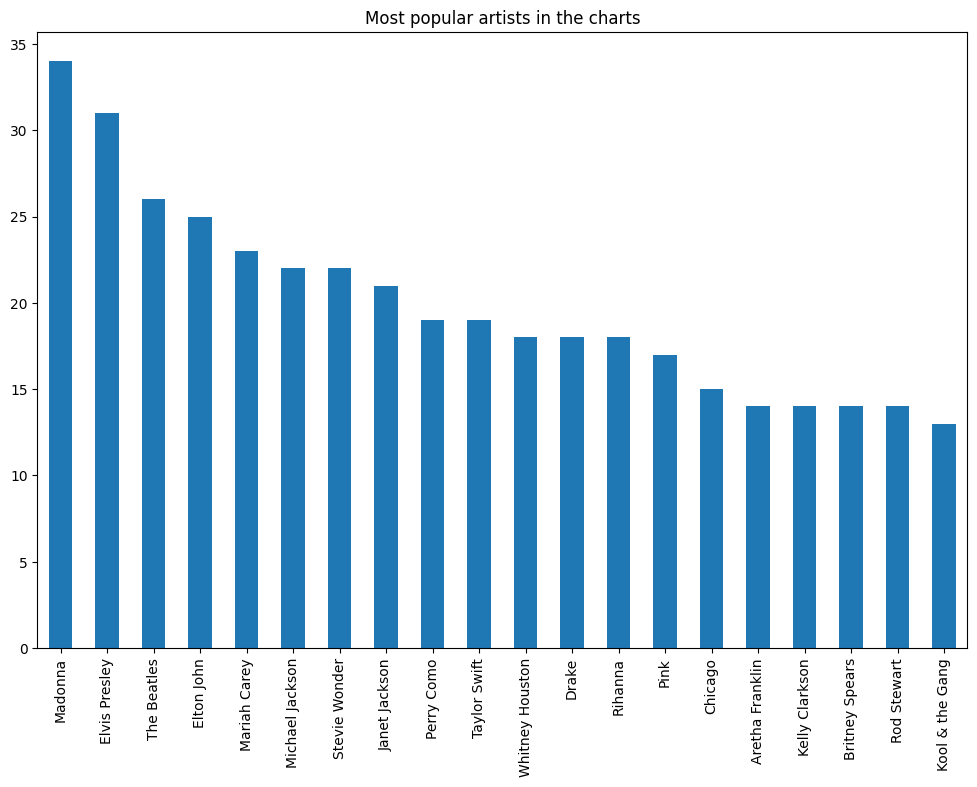

In [15]:
# Here we show the artists with the most songs in the top 100 of all times
plt.figure(figsize=(12, 8))
df['Artist_Feat'].value_counts()[:20].plot(kind="bar")
plt.title("Most popular artists in the charts")
plt.show()

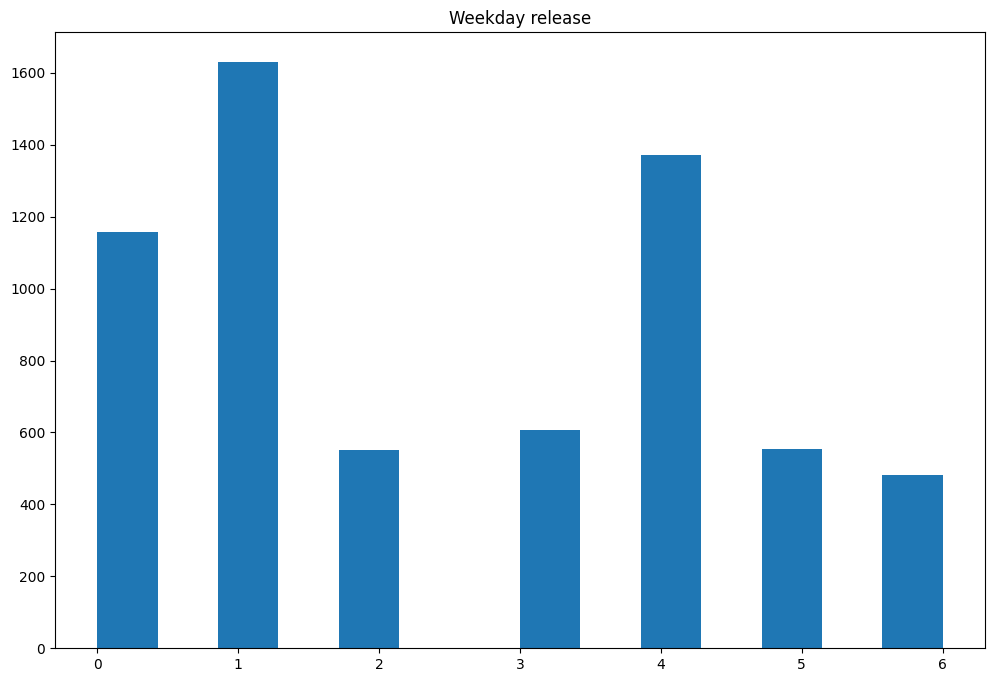

In [16]:
plt.figure(figsize=(12, 8))
plt.hist(df['weekday_release'], bins=14)
plt.title("Weekday release")
plt.show()


# We can see that most songs are released on Friday (4) and Tuesday (1).
## What about the release month?

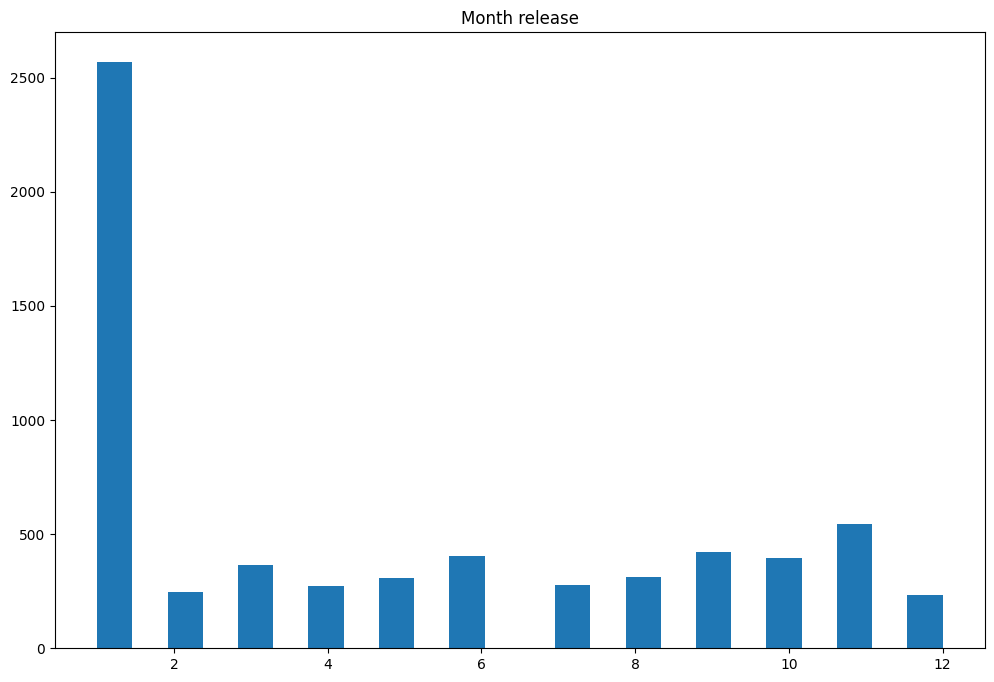

In [17]:
plt.figure(figsize=(12, 8))
plt.hist(df['month_release'], bins=24)
plt.title("Month release")
plt.show()

## Seems like January is the most popular month for songs to be realeased at.
## But we need to be careful as some missing data might be filled by default to January 1st.

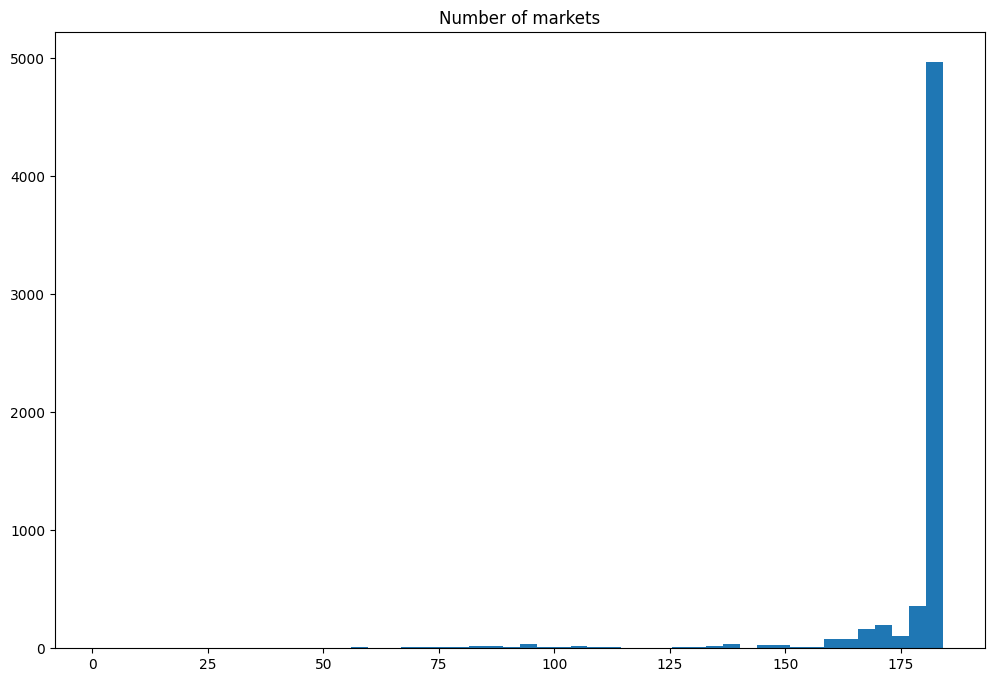

In [18]:
plt.figure(figsize=(12, 8))
plt.hist(df['available_markets'], bins=50)
plt.title("Number of markets")
plt.show()


## So unsuprisnigly, most songs are released to almost all markets

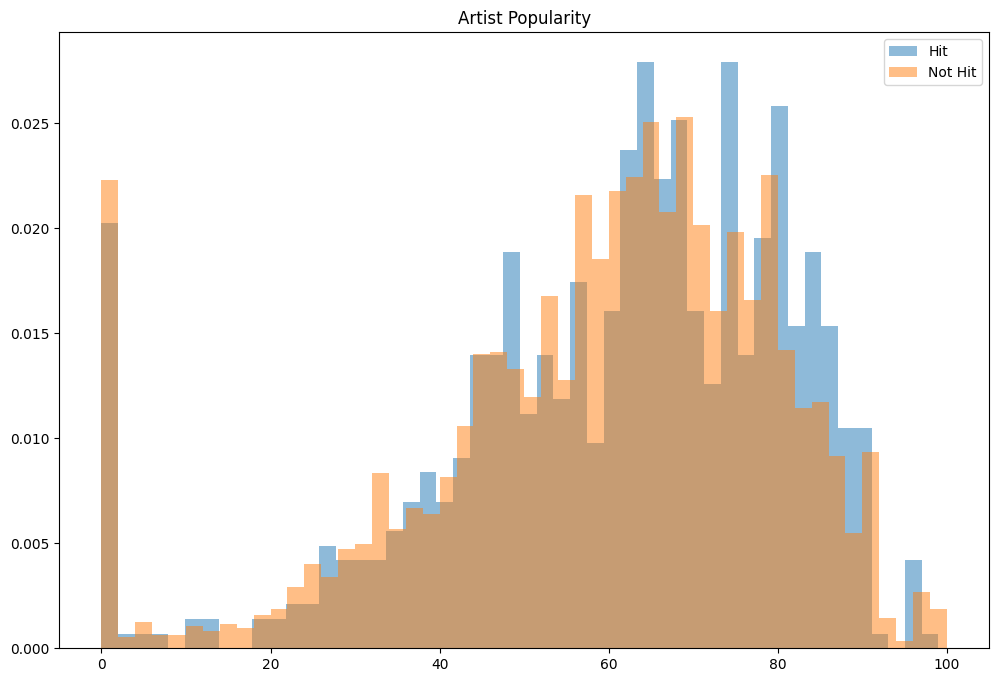

In [19]:
plt.figure(figsize=(12, 8))
plt.hist(df[df['Hit'] == 1]['popularity'], bins=50,
         density=True, alpha=0.5, label="Hit")
plt.hist(df[df['Hit'] == 0]['popularity'], bins=50,
         density=True, alpha=0.5, label="Not Hit")
plt.title("Artist Popularity")
plt.legend()
plt.show()


## Seems like the hits and non hits spread pretty evenly, with a slight advantage to the hits.
## It means that the popularity might not affect the prediction as much as we thought.

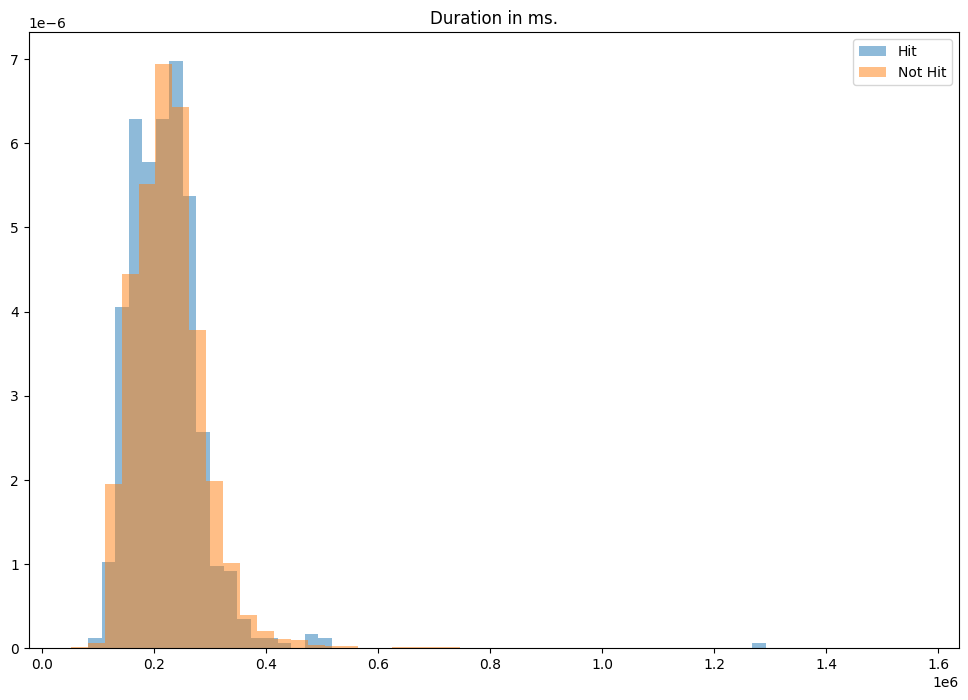

In [20]:
plt.figure(figsize=(12, 8))
plt.hist(df[df['Hit'] == 1]['duration_ms'], bins=50,
         density=True, alpha=0.5, label="Hit")
plt.hist(df[df['Hit'] == 0]['duration_ms'], bins=50,
         density=True, alpha=0.5, label="Not Hit")
plt.title("Duration in ms.")
plt.legend()
plt.show()


## The song duration distribution seems similar.
## We did not expect it to matter to much but better to check before moving forward.

In [21]:
df = df.drop(columns=['lookup'])

In [22]:
def transfer_str_to_numeric_vals(dataset):
    df_change = dataset.copy()
    df_change.dropna(inplace=True)
    df_change.drop_duplicates(inplace=True)
    
    return df_change.apply(lambda x: pd.factorize(x, sort=True)[0])


In [23]:
def get_classifier_obj(classifier_name, params):
    ###
    if classifier_name == 'KNN':
        if params == None:
            clf = KNeighborsClassifier()
            return clf
        else:
            clf = KNeighborsClassifier(n_neighbors=params['n_neighbors'])
            return clf

    if classifier_name == 'random_forest':
        if params == None:
            return RandomForestClassifier()
        else:
            return RandomForestClassifier(n_estimators=params['n_estimators'])

    if classifier_name == 'decision_tree':
        if params == None:
            return tree.DecisionTreeClassifier()
        else:
            return tree.DecisionTreeClassifier(max_depth=params["max_depth"],
                                               min_samples_split=params["min_samples_split"])

    if classifier_name == 'naive_bayes':
        return GaussianNB()

    if classifier_name == 'svm':
        return SVC()

In [24]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    #split
    X = dataset.drop(columns=label_column)
    y = dataset[label_column]

    #train
    X_train, X_test = train_test_split(
        X, train_size=1-test_ratio, random_state=rand_state)
    Y_train, Y_test = train_test_split(
        y, train_size=1-test_ratio, random_state=rand_state)
    return X_train, X_test, Y_train, Y_test


In [25]:
test_ratio, rand_state = 0.2, 42
category_col_name = 'Hit'
dataset = transfer_str_to_numeric_vals(df)
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, category_col_name, test_ratio, rand_state)


In [26]:
def calc_evaluation_val(eval_metric, y_test, y_predicted):

    if eval_metric == "accuracy":
        return metrics.accuracy_score(y_test, y_predicted)

    elif eval_metric == "precision":
        return metrics.precision_score(y_test, y_predicted)

    elif eval_metric == "recall":
        return metrics.recall_score(y_test, y_predicted, average='micro')

    elif eval_metric == "f1":
        return metrics.f1_score(y_test, y_predicted)

    else:  # confusion_matrix
        return confusion_matrix(y_test, y_predicted)


In [27]:
def find_best_k_for_KNN(X_train, y_train):
    ###
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors': [3, 7, 9, 11]}
    clf = GridSearchCV(knn, parameters, scoring=make_scorer(
        metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    return clf.best_params_['n_neighbors'], clf.best_score_


In [28]:
test_ratio, rand_state = 0.5, 42
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, category_col_name, test_ratio, rand_state)
best_K, best_f1_KNN_params = find_best_k_for_KNN(X_train, y_train)


In [29]:
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth': [2, 4, 6], "min_samples_split": [5, 10, 20]}
    dtree = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dtree, parameters, scoring=make_scorer(
        metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_max_depth = clf.best_params_['max_depth']
    best_min_samples_split = clf.best_params_["min_samples_split"]
    best_f1_val = clf.best_score_
    return best_max_depth, best_min_samples_split, best_f1_val


In [30]:
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, category_col_name, test_ratio, rand_state)
best_max_dep, best_min_smpl_splt, best_f1_DT_params = find_best_decision_tree_params(
    X_train, y_train)


In [31]:
def find_best_random_forest_num_estimators(X_train, y_train):
    parameters = {'n_estimators': [11, 51, 71]}
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters, scoring=make_scorer(
        metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_num_estimators = clf.best_params_['n_estimators']
    best_f1_val = clf.best_score_
    return best_num_estimators, best_f1_val

In [32]:
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, category_col_name, test_ratio, rand_state)
best_n_estimators, best_f1_RF_params = find_best_random_forest_num_estimators(
    X_train, y_train)


In [33]:
def find_best_model(X_train, y_train, max_depth_val, min_samples_split_val):
    parameters = {'max_depth': max_depth_val,
                  "min_samples_split": min_samples_split_val}
    best_clf = None
    best_recall_val = -1
    algos = ["svm", "naive_bayes", "decision_tree"]

    for alg in algos:
        clf = get_classifier_obj(alg, parameters)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        recall = calc_evaluation_val('recall', y_train, y_pred_train)
        print(clf, recall)
        if recall > best_recall_val:
            best_recall_val = recall
            best_clf = clf

    return best_clf, best_recall_val


In [34]:
test_ratio, rand_state = 0.2, 42
max_dep = 4
min_smpl_splt = 5
dataset
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, category_col_name, test_ratio, rand_state)
best_clf, best_recall_val = find_best_model(
    X_train, y_train, max_dep, min_smpl_splt)
print("KNN Accuracy: ", best_f1_KNN_params)
print("random forest Accuracy: ", best_f1_RF_params)


SVC() 0.8842975206611571
GaussianNB() 0.8508461235733963
DecisionTreeClassifier(max_depth=4, min_samples_split=5) 0.8864620228256592
KNN Accuracy:  0.07720583600370681
random forest Accuracy:  0.019762351469668545


In [35]:
print(best_clf, best_recall_val)

DecisionTreeClassifier(max_depth=4, min_samples_split=5) 0.8864620228256592


# Lastly, let's try to use LinearRegression to predict
# popularity scores of different songs rather than 'Hit'
### (The reason we did not choose this is because spotify's popularity is mostly based on when people heared a song and not just based on number of listens)
### But why not give it a try anyway :)

#### Not the best prediction, but this was predicted as the popularity is based on current time, and when people listened to the song, which is data we don't have a way to acquire.

RMSE:  14.200964449116134
Popularity Mean  58.67779002046277


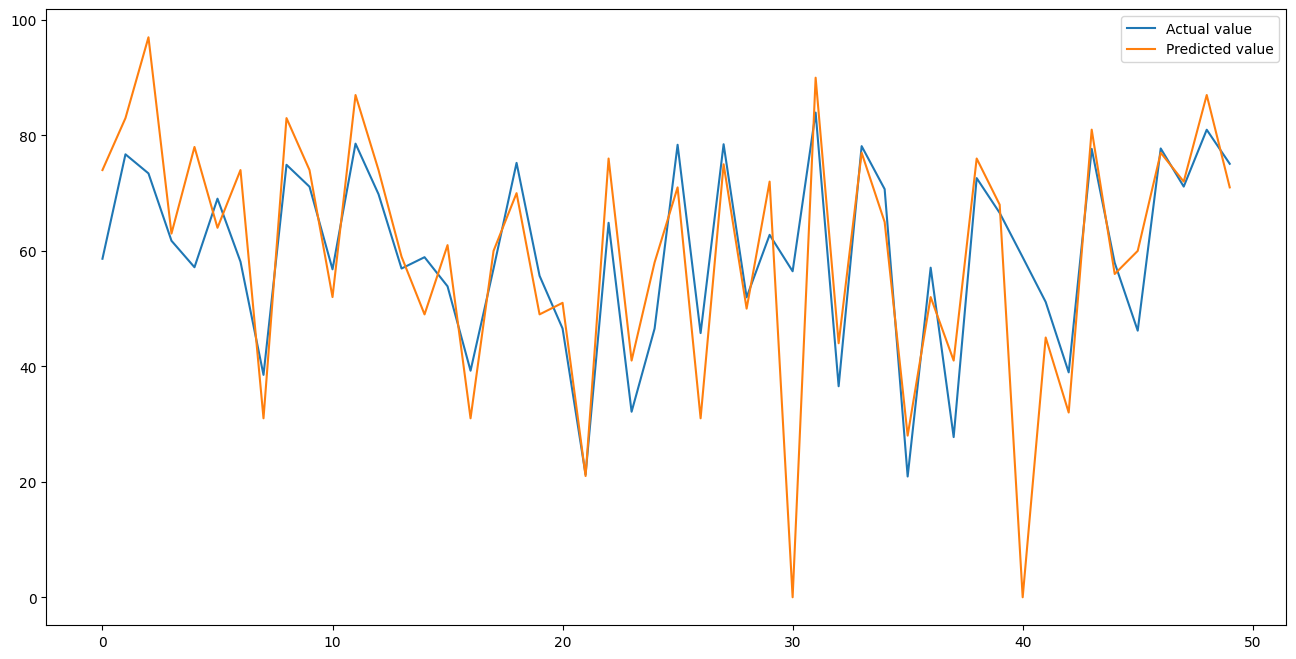

In [36]:
X_train, X_test, y_train, y_test = split_to_train_and_test(
    dataset, 'popularity', test_ratio, rand_state)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
LinearRegression()

y_pred = model.predict(X_test)

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Popularity Mean ', df['popularity'].mean())

test = pd.DataFrame({'Predicted value': y_pred, 'Actual value': y_test})
fig = plt.figure(figsize=(16, 8))
test = test.reset_index()
test = test.drop(['index'], axis=1)
plt.plot(test[:50])
plt.legend(['Actual value', 'Predicted value'])


# Conclusion:

## We scraped wikipedia's billbard pages, and used spotify's api to get a good chunk of data
## We cleaned the data to be able to work with it
## We visualized the data and played with it to be able to get better predictions by it
## We managed to create a model of machine learning to predict if a song will become a 'Hit' song with a score of 0.88 / 1 !

# To sum up, we managed to answer the research question of predicting a song to be a 'Hit' or not based on it's features.